In [1]:
from imports import *

In [2]:
from scipy.optimize import curve_fit
def fit_func(x, a, b):
    return a*x + b

In [3]:
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
table = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue.fits' %root_dir)
table

<QTable length=8700>
gal_name region_ID  x_max  ... TEM_NII_ERR_MUSE TEM_SIII_MUSE TEM_SIII_ERR_MUSE
                     pix   ...        K               K               K        
bytes32   float64  float64 ...     float64         float64         float64     
-------- --------- ------- ... ---------------- ------------- -----------------
  IC5332       3.0    43.0 ...              ———           ———               ———
  IC5332       7.0    50.0 ...              ———           ———               ———
  IC5332       9.0    28.0 ...              ———           ———               ———
  IC5332      10.0    42.0 ...              ———           ———               ———
  IC5332      11.0    29.0 ...              ———           ———               ———
  IC5332      15.0    34.0 ...              ———           ———               ———
  IC5332      17.0    67.0 ...              ———           ———               ———
  IC5332      18.0    36.0 ...              ———           ———               ———
  IC5332      19.0    36.0 ...              ———           ———               ———
     ...       ...     ... ...              ...           ...               ...
 NGC7496     707.0    30.0 ...              ———           ———               ———
 NGC7496     721.0    54.0 ...              ———           ———               ———
 NGC7496     725.0    32.0 ...              ———           ———               ———
 NGC7496     726.0    33.0 ...              ———           ———               ———
 NGC7496     735.0    27.0 ...              ———           ———               ———
 NGC7496     743.0    32.0 ...              ———           ———               ———
 NGC7496     744.0    28.0 ...              ———           ———               ———
 NGC7496     765.0    25.0 ...              ———           ———               ———
 NGC7496     773.0    29.0 ...              ———           ———               ———
 NGC7496     776.0    31.0 ...              ———           ———               ———

In [4]:
# Load sample table 
sample_table_file = '%s/data_misc/sample_table/phangs_sample_table_v1p6.fits' %root_dir
sample_table = QTable.read(sample_table_file)

# Load the MUSE table
muscat_table_file = '%s/data_misc/Nebulae_catalogue_v4/Nebulae_catalogue_v4.fits' %root_dir
table_muse = QTable.read(muscat_table_file)

# Make column names consistent
columns = table_muse.colnames
for column in columns:
    table_muse.rename_column(column, column+'_MUSE')
table_muse.rename_column('gal_name_MUSE', 'gal_name')
table_muse.rename_column('region_ID_MUSE', 'region_ID')
table_muse.rename_column('Lum_HA6562_CORR_MUSE', 'HA6562_LUMINOSITY_MUSE')

# Get radius in pc
for gal_name in np.unique(table_muse['gal_name']):
    mask = sample_table['name'] == gal_name.lower()
    dist = sample_table['dist'][mask][0]
    table_muse['region_circ_rad_pc_MUSE'] = cat_props.calculate_radius(table_muse['region_circ_rad_MUSE'], dist)  

table_muse

<QTable length=31497>
gal_name region_ID ... TEM_SIII_ERR_MUSE region_circ_rad_pc_MUSE
                   ...         K                    pc          
bytes32   float64  ...      float64              float64        
-------- --------- ... ----------------- -----------------------
  IC5332       0.0 ...               ———      111.24393696640297
  IC5332       1.0 ...               ———       57.93090802750168
  IC5332       2.0 ...               ———       56.09136050529689
  IC5332       3.0 ...               ———       82.56424710829474
  IC5332       4.0 ...               ———       56.09136050529689
  IC5332       5.0 ...               ———       56.09136050529689
  IC5332       6.0 ...               ———      54.189402485905866
  IC5332       7.0 ...               ———       99.28857403103791
  IC5332       8.0 ...               ———       57.93090802750168
     ...       ... ...               ...                     ...
 NGC7496     767.0 ...               ———      59.713813196332865
 NGC7496     768.0 ...               ———      59.713813196332865
 NGC7496     769.0 ...               ———       58.82911520385716
 NGC7496     770.0 ...               ———       57.01855324465027
 NGC7496     771.0 ...               ———       57.93090802750168
 NGC7496     772.0 ...               ———      59.713813196332865
 NGC7496     773.0 ...               ———      59.713813196332865
 NGC7496     774.0 ...               ———       61.44500685981095
 NGC7496     775.0 ...               ———       57.01855324465027
 NGC7496     776.0 ...               ———       61.44500685981095

In [5]:
mask_flags = ~((table['flag_edge_hst']==1)|(table['flag_edge_MUSE']==1)|(table['flag_star_MUSE']==1))
table = table[mask_flags]

mask_flags = ~((table_muse['flag_edge_MUSE']==1)|(table_muse['flag_star_MUSE']==1))
table_muse = table_muse[mask_flags] 

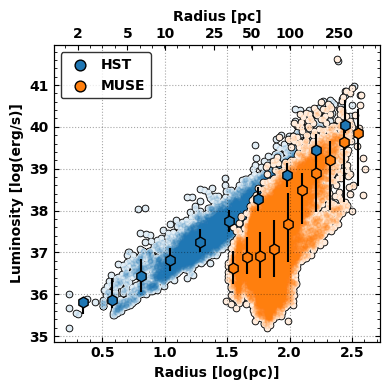

In [6]:
data_x1 = np.log10(table['radius_circ_pc'].value)
data_y1 = np.log10(table['HA6562_LUMINOSITY_HST'].value)

# data_x2 = np.log10(table['region_circ_rad_pc_MUSE'].value)
# data_y2 = np.log10(table['HA6562_LUMINOSITY_MUSE'].value)

data_x2 = np.log10(table_muse['region_circ_rad_pc_MUSE'].value)
data_y2 = np.log10(table_muse['HA6562_LUMINOSITY_MUSE'].value)

fig = plt.figure(figsize=(4, 4)) 
ax = fig.add_subplot(111)

for i, (data_x, data_y) in enumerate(zip([data_x1, data_x2], [data_y1, data_y2])):

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)
    ax.scatter(data_x, data_y, s=10, alpha=0.1, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x, data_y)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1.5)
    ax.scatter(x, y, s=60, ec='black', zorder=10, marker='h', c='C%i'%i)

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius [log(pc)]')
ax.set_ylabel('Luminosity [log(erg/s)]')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.log10([2,5,10,25,50,100,250])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(np.round(np.power(10, new_tick_locations)).astype(int))
ax2.set_xlabel('Radius [pc]')

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.scatter([], [], s=60, ec='black', fc='C0', zorder=10, label='HST')
ax.scatter([], [], s=60, ec='black', fc='C1', zorder=10, label='MUSE')
ax.legend(loc='upper left', edgecolor='black', handletextpad=0.5)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/scatter_radlum_all_wmuse.pdf', dpi=200, bbox_inches='tight')

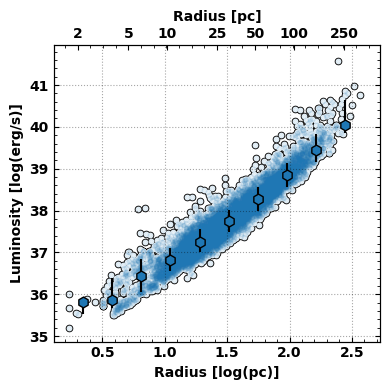

In [7]:
data_x = np.log10(table['radius_circ_pc'].value)
data_y = np.log10(table['HA6562_LUMINOSITY_HST'].value)

fig = plt.figure(figsize=(4, 4)) 
ax = fig.add_subplot(111)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)
ax.scatter(data_x, data_y, s=10, alpha=0.1, rasterized=True)

x, y, stats, bins = get_bins_1d(data_x, data_y)
ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1.5)
ax.scatter(x, y, s=60, ec='black', fc='C0', zorder=10, marker='h')

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius [log(pc)]')
ax.set_ylabel('Luminosity [log(erg/s)]')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.log10([2,5,10,25,50,100,250])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(np.round(np.power(10, new_tick_locations)).astype(int))
ax2.set_xlabel('Radius [pc]')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/scatter_radlum_all.pdf', dpi=200, bbox_inches='tight')

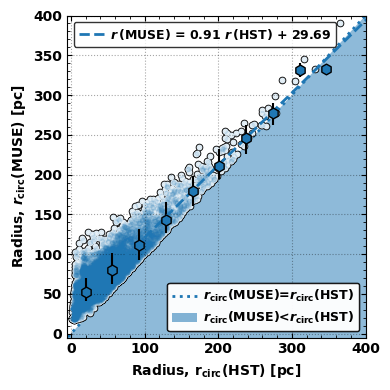

In [8]:
data_x = table['radius_circ_pc'].value
data_y = table['region_circ_rad_pc_MUSE'].value

fig = plt.figure(figsize=(4, 4)) 
ax = fig.add_subplot(111)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)
ax.scatter(data_x, data_y, s=10, alpha=0.1, rasterized=True)

x, y, stats, bins = get_bins_1d(data_x, data_y)
ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1.5)
ax.scatter(x, y, s=60, ec='black', fc='C0', zorder=10, marker='h')

params = curve_fit(fit_func, x, y)
xs = np.linspace(0, 500, 100)
ys = fit_func(xs, *params[0])

line1,  = ax.plot(xs, ys, color='C0', lw=2, ls='--', label='$r$(MUSE) = %.2f $r$(HST) + %.2f' %tuple(params[0]))

line2, = ax.plot([-100,500], [-100,500], color='C0', lw=2, ls=':', label='y=x', zorder=0)
line3 = ax.fill_between([-100,500], [-100,500], fc='C0', ec='none', alpha=0.5, label='y<x', y2=-10, zorder=0)

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius, r$_\mathrm{circ}$(HST) [pc]')
ax.set_ylabel('Radius, $r_\mathrm{circ}$(MUSE) [pc]')

ax.set_xlim(-5, 400)
ax.set_ylim(-5, 400)

# legend1 = ax.legend(loc='lower right', edgecolor='black', handletextpad=0.5, fontsize=9)
# legend2 = ax.legend(loc='lower right', edgecolor='black', handletextpad=0.5, fontsize=9)

lines = ax.get_lines()
legend1 = plt.legend([line1], [r'$r\,$(MUSE) = %.2f $r\,$(HST) + %.2f' %tuple(params[0])], loc='upper left', edgecolor='black', handletextpad=0.5, fontsize=9)
legend2 = plt.legend([line2, line3], ['$r_\mathrm{circ}$(MUSE)=$r_\mathrm{circ}$(HST)','$r_\mathrm{circ}$(MUSE)<$r_\mathrm{circ}$(HST)'], loc='lower right', edgecolor='black', handletextpad=0.5, fontsize=9)
ax.add_artist(legend1)
ax.add_artist(legend2)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/scatter_radrad_all.pdf', dpi=200, bbox_inches='tight')

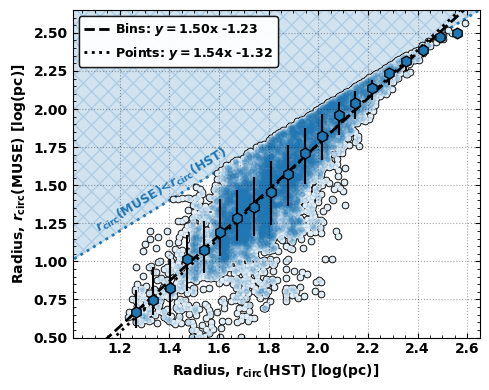

In [9]:
data_x = np.log10(table['region_circ_rad_pc_MUSE'].value)
data_y = np.log10(table['radius_circ_pc'].value)

fig = plt.figure(figsize=(5, 4)) 
ax = fig.add_subplot(111)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)
ax.scatter(data_x, data_y, s=10, alpha=0.1, rasterized=True)

x, y, stats, bins = get_bins_1d(data_x, data_y, nbins=20)
ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1.5)
ax.scatter(x, y, s=60, ec='black', fc='C0', zorder=10, marker='h')

params1a = curve_fit(fit_func, x, y)
xs = np.linspace(0, 500, 100)
ys = fit_func(xs, *params1a[0])

line1a,  = ax.plot(xs, ys, color='k', lw=2, ls='--', label='Bins: $r$(MUSE) = %.2f $r$(HST) + %.2f' %tuple(params1a[0]))

params1b = curve_fit(fit_func, data_x, data_y)
xs = np.linspace(0, 500, 100)
ys = fit_func(xs, *params1b[0])

line1b,  = ax.plot(xs, ys, color='k', lw=2, ls=':', label='Points: $r$(MUSE) = %.2f $r$(HST) + %.2f' %tuple(params1b[0]))

line2, = ax.plot([-100,500], [-100,500], color='C0', lw=2, ls=':', label='y=x', zorder=0)
line3 = ax.fill_between([-100,500], [-100,500], fc='C0', label='y<x', y2=1e4, hatch='XX', zorder=-1, edgecolor='C0', alpha=0.2, rasterized=True)

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius, r$_\mathrm{circ}$(HST) [log(pc)]')
ax.set_ylabel('Radius, $r_\mathrm{circ}$(MUSE) [log(pc)]')

ax.set_xlim(1.01, 2.65)
ax.set_ylim(0.5, 2.65)

lines = ax.get_lines()
legend1 = plt.legend([line1a, line1b], 
                     [r'Bins: $y= %.2f $x %.2f' %tuple(params1a[0]), 
                      r'Points: $y= %.2f $x %.2f' %tuple(params1b[0])], 
                     loc='upper left', edgecolor='black', handletextpad=0.5, fontsize=9)
# legend2 = plt.legend([line2, line3], ['$r_\mathrm{circ}$(MUSE)=$r_\mathrm{circ}$(HST)','$r_\mathrm{circ}$(MUSE)<$r_\mathrm{circ}$(HST)'], loc='lower right', 
#                      edgecolor='black', handletextpad=0.5, fontsize=9)

ax.text(0.05, 0.45, '$r_\mathrm{circ}$(MUSE)<$r_\mathrm{circ}$(HST)', transform=ax.transAxes, fontsize=9, ha='left', va='center', color='C0', rotation=31)

ax.add_artist(legend1)
# ax.add_artist(legend2)

# ax.set_aspect('equal')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/scatter_radrad_log_all.pdf', dpi=200, bbox_inches='tight')

In [10]:
fit = params[0]
fit_err = np.sqrt(np.diag(params[1]))
print('%0.2f $\pm$ %0.2f, %0.2f $\pm$ %0.2f' %(fit[0], fit_err[0], fit[1], fit_err[1]))

0.91 $\pm$ 0.03, 29.69 $\pm$ 5.39


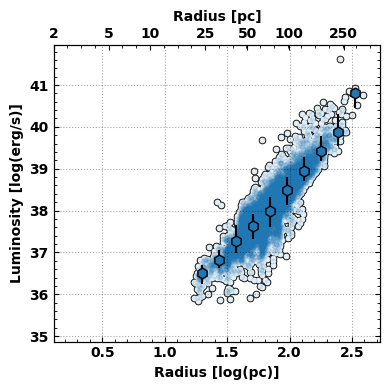

In [11]:
data_x = np.log10(table['region_circ_rad_pc_MUSE'].value)
data_y = np.log10(table['HA6562_LUMINOSITY_MUSE'].value)

fig = plt.figure(figsize=(4, 4)) 
ax = fig.add_subplot(111)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)
ax.scatter(data_x, data_y, s=10, alpha=0.1, rasterized=True)

x, y, stats, bins = get_bins_1d(data_x, data_y)
ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1.5)
ax.scatter(x, y, s=60, ec='black', fc='C0', zorder=10, marker='h')

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius [log(pc)]')
ax.set_ylabel('Luminosity [log(erg/s)]')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.log10([2,5,10,25,50,100,250])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(np.round(np.power(10, new_tick_locations)).astype(int))
ax2.set_xlabel('Radius [pc]')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/scatter_radlum_all_muse.pdf', dpi=200, bbox_inches='tight')

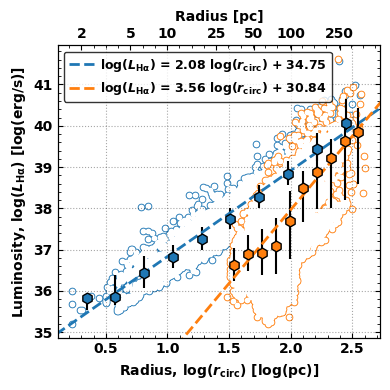

In [12]:
data_x1 = np.log10(table['radius_circ_pc'].value)
data_y1 = np.log10(table['HA6562_LUMINOSITY_HST'].value)

# data_x2 = np.log10(table['region_circ_rad_pc_MUSE'].value)
# data_y2 = np.log10(table['HA6562_LUMINOSITY_MUSE'].value)

data_x2 = np.log10(table_muse['region_circ_rad_pc_MUSE'].value)
data_y2 = np.log10(table_muse['HA6562_LUMINOSITY_MUSE'].value)

fig = plt.figure(figsize=(4, 4)) 
ax = fig.add_subplot(111)

for i, (data_x, data_y) in enumerate(zip([data_x1, data_x2], [data_y1, data_y2])):

    ax.scatter(data_x, data_y, s=20, c='C%i' %i, rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)
    # ax.scatter(data_x, data_y, s=10, alpha=0.1, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x, data_y)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1.5)
    ax.scatter(x, y, s=60, ec='black', zorder=10, marker='h', c='C%i'%i)

    from scipy.optimize import curve_fit
    def fit_func(x, a, b):
        return a*x + b
    params = curve_fit(fit_func, x, y)
    xs = np.linspace(0, 3, 100)
    ys = fit_func(xs, *params[0])
    ax.plot(xs, ys, color='C%i'%i, lw=2, ls='--', label=r'log($L_\mathrm{H\alpha}$) = %.2f log($r_\mathrm{circ}$) + %.2f' %tuple(params[0]))

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel(r'Radius, log($r_\mathrm{circ}$) [log(pc)]')
ax.set_ylabel(r'Luminosity, log($L_\mathrm{H\alpha}$) [log(erg/s)]')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.log10([2,5,10,25,50,100,250])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(np.round(np.power(10, new_tick_locations)).astype(int))
ax2.set_xlabel('Radius [pc]')

ax.legend(loc='upper left', edgecolor='black', handletextpad=0.5, fontsize=9)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/scatter_radlum_all_wmuse_wfit.pdf', dpi=200, bbox_inches='tight')

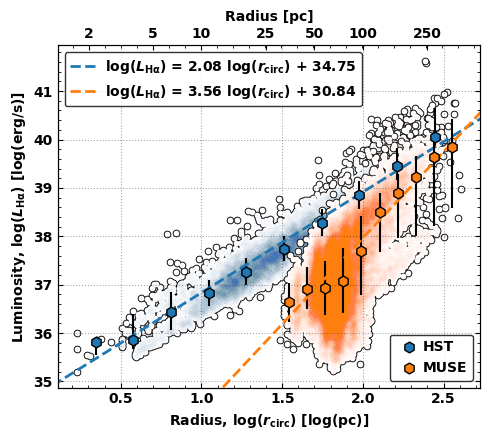

In [13]:
data_x1 = np.log10(table['radius_circ_pc'].value)
data_y1 = np.log10(table['HA6562_LUMINOSITY_HST'].value)

data_x2 = np.log10(table_muse['region_circ_rad_pc_MUSE'].value)
data_y2 = np.log10(table_muse['HA6562_LUMINOSITY_MUSE'].value)

fig = plt.figure(figsize=(5, 4.5)) 
ax = fig.add_subplot(111)

for i, (data_x, data_y) in enumerate(zip([data_x1, data_x2], [data_y1, data_y2])):

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)
    ax.scatter(data_x, data_y, s=10, alpha=0.01, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x, data_y)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1.5)
    ax.scatter(x, y, s=60, ec='black', zorder=10, marker='h', c='C%i'%i)

    from scipy.optimize import curve_fit
    def fit_func(x, a, b):
        return a*x + b
    params = curve_fit(fit_func, x, y)
    xs = np.linspace(0, 3, 100)
    ys = fit_func(xs, *params[0])
    ax.plot(xs, ys, color='C%i'%i, lw=2, ls='--', label=r'log($L_\mathrm{H\alpha}$) = %.2f log($r_\mathrm{circ}$) + %.2f' %tuple(params[0]))

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel(r'Radius, log($r_\mathrm{circ}$) [log(pc)]')
ax.set_ylabel(r'Luminosity, log($L_\mathrm{H\alpha}$) [log(erg/s)]')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.log10([2,5,10,25,50,100,250])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(np.round(np.power(10, new_tick_locations)).astype(int))
ax2.set_xlabel('Radius [pc]')

ax.legend(loc='upper left', edgecolor='black', handletextpad=0.5)

ax2.scatter([], [], s=60, ec='black', zorder=10, marker='h', c='C0', label='HST')
ax2.scatter([], [], s=60, ec='black', zorder=10, marker='h', c='C1', label='MUSE')
ax2.legend(loc='lower right', edgecolor='black', handletextpad=0)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/scatter_radlum_all_wmuse.pdf', dpi=200, bbox_inches='tight')

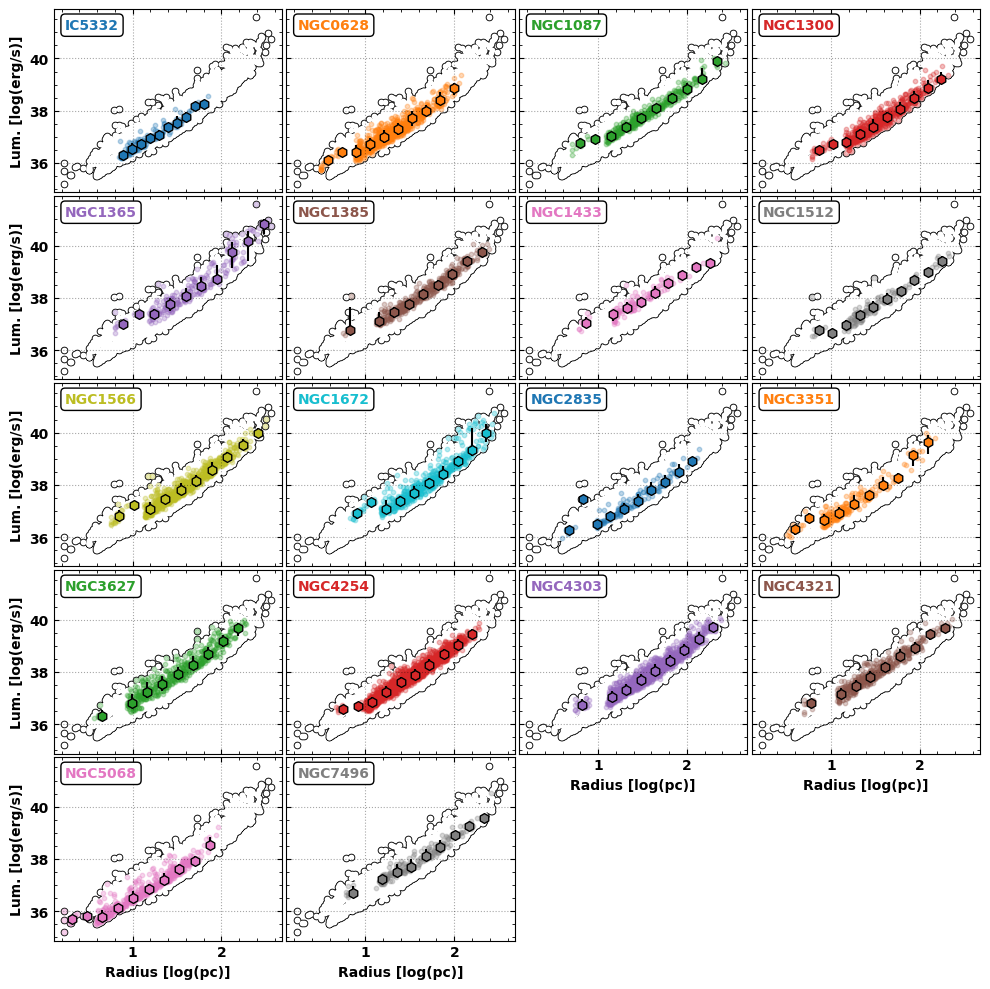

In [14]:
data_x = np.log10(table['radius_circ_pc'].value)
data_y = np.log10(table['HA6562_LUMINOSITY_HST'].value)

fig = plt.figure(figsize=(10, 10)) 

gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    ax.scatter(data_x_, data_y_, s=10, c='C%i'%i, alpha=0.3, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1.5)
    ax.scatter(x, y, s=50, ec='black', fc='C%i' %i, zorder=10, marker='h')

    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [14,15,16,17]:
        ax.set_xlabel('Radius [log(pc)]')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12,16]:
        ax.set_ylabel('Lum. [log(erg/s)]')
    else:
        ax.set_yticklabels([])

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_radlum_sep.pdf', dpi=150, bbox_inches='tight')

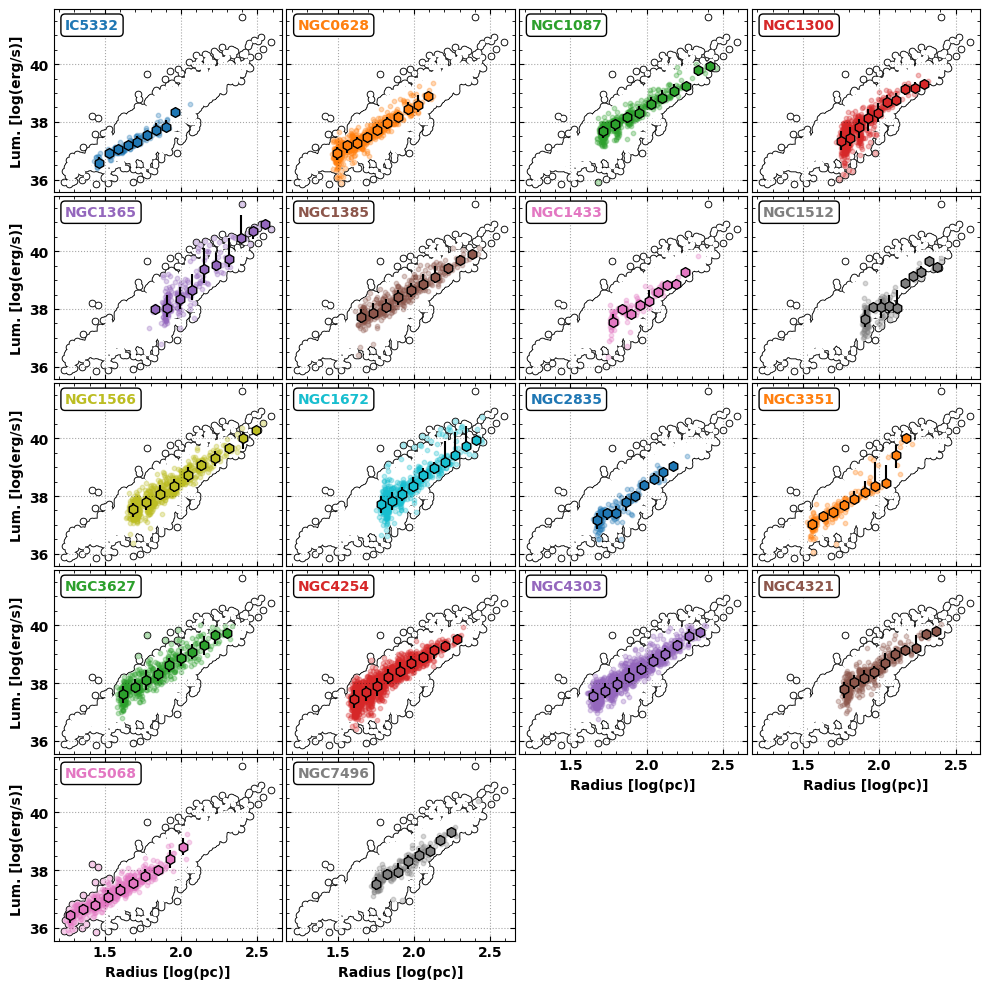

In [15]:
data_x = np.log10(table['region_circ_rad_pc_MUSE'].value)
data_y = np.log10(table['HA6562_LUMINOSITY_MUSE'].value)

fig = plt.figure(figsize=(10, 10)) 

gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    ax.scatter(data_x_, data_y_, s=10, c='C%i'%i, alpha=0.3, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1.5)
    ax.scatter(x, y, s=50, ec='black', fc='C%i' %i, zorder=10, marker='h')

    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [14,15,16,17]:
        ax.set_xlabel('Radius [log(pc)]')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12,16]:
        ax.set_ylabel('Lum. [log(erg/s)]')
    else:
        ax.set_yticklabels([])

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_radlum_sep_muse.pdf', dpi=150, bbox_inches='tight')

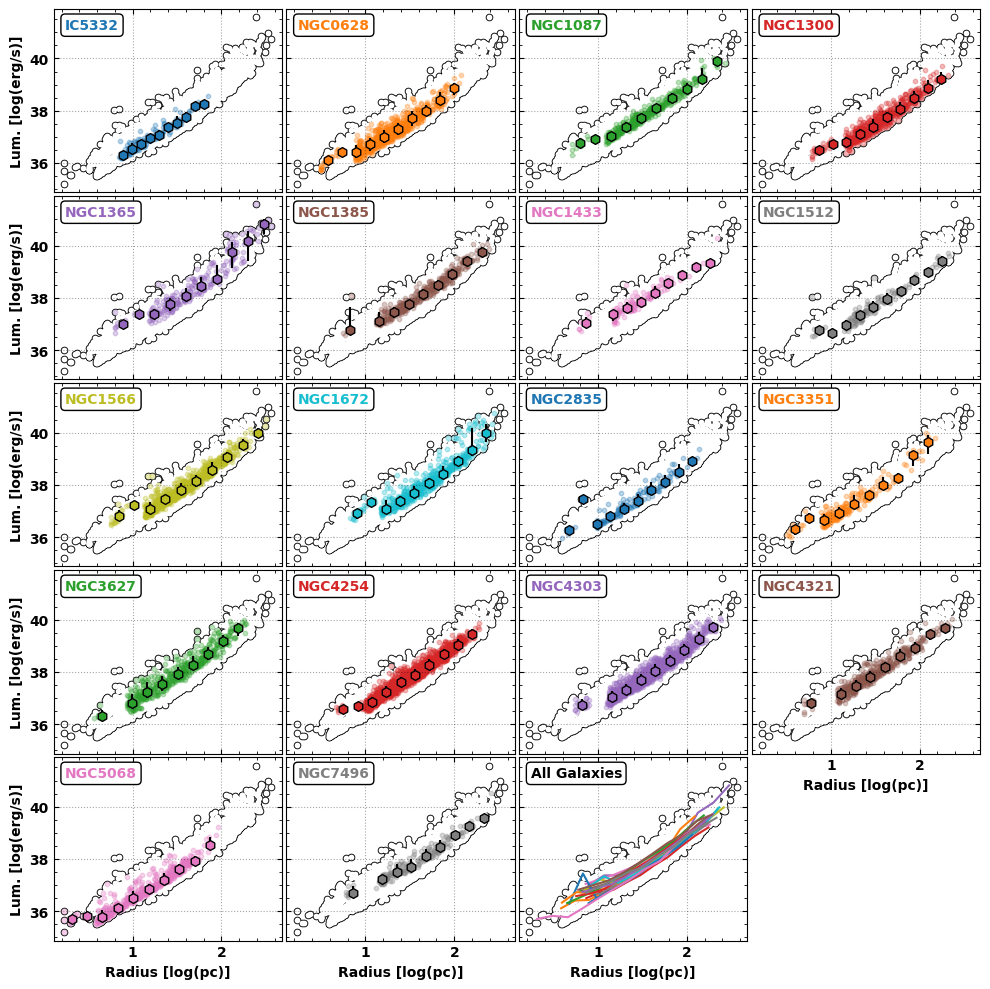

In [16]:
data_x = np.log10(table['radius_circ_pc'].value)
data_y = np.log10(table['HA6562_LUMINOSITY_HST'].value)

fig = plt.figure(figsize=(10, 10)) 

gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    ax.scatter(data_x_, data_y_, s=10, c='C%i'%i, alpha=0.3, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1.5)
    ax.scatter(x, y, s=50, ec='black', fc='C%i' %i, zorder=10, marker='h')

    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [15,16,17]:
        ax.set_xlabel('Radius [log(pc)]')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12,16]:
        ax.set_ylabel('Lum. [log(erg/s)]')
    else:
        ax.set_yticklabels([])

ax = fig.add_subplot(5,4,i+2)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

for i, gal_name in enumerate(gal_names):

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.plot(x, y, c='C%i' %i)

    ax.set_yticklabels([])

ax.grid(True, alpha=0.35, ls=':', color='black')
ax.text(0.05, 0.95, 'All Galaxies', ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='k')
ax.set_xlabel('Radius [log(pc)]')

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_radlum_sep.pdf', dpi=150, bbox_inches='tight')

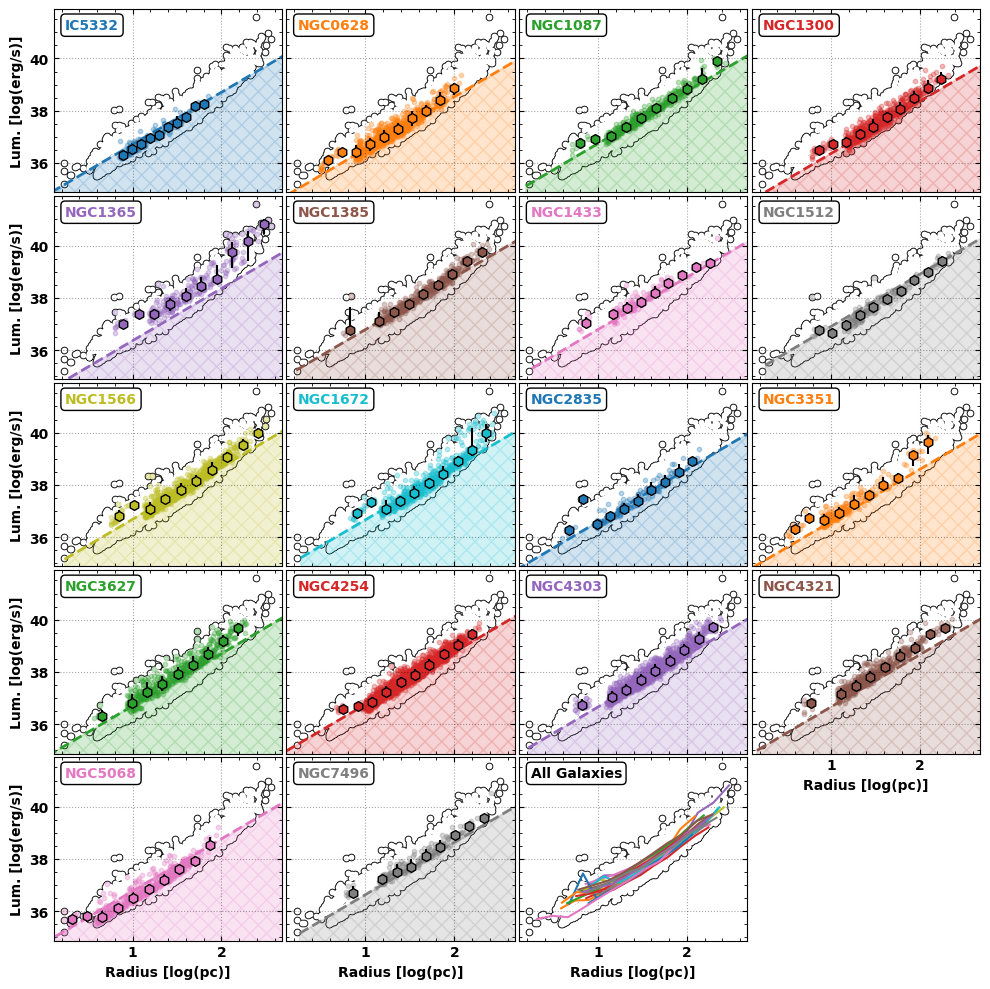

In [17]:
# Get Flux and noise stats
table_noisestats = QTable.read('./tabs/galmap_props.fits')
table_noisestats

sigma = 3
std = (table_noisestats['median'] * 1e-20 * u.erg / (u.cm ** 2) / u.s) 
std = std * sigma
pix = 0.04 * u.arcsec / 2
pix_pc = np.ones(len(std)) * u.pc
std_lum = np.ones(len(std)) * u.erg / u.s

# Get radius in pc
for i, gal_name in enumerate(np.unique(table['gal_name'])):
    mask = sample_table['name'] == gal_name.lower()
    dist = sample_table['dist'][mask][0]
    pix_pc[i] = cat_props.calculate_radius(pix, dist)  
    std_lum[i] = cat_props.calculate_luminosity(std[i], dist)

data_x = np.log10(table['radius_circ_pc'].value)
data_y = np.log10(table['HA6562_LUMINOSITY_HST'].value)

fig = plt.figure(figsize=(10, 10)) 

gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    ax.scatter(data_x_, data_y_, s=10, c='C%i'%i, alpha=0.3, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1.5)
    ax.scatter(x, y, s=50, ec='black', fc='C%i' %i, zorder=10, marker='h')

    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [15,16,17]:
        ax.set_xlabel('Radius [log(pc)]')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12,16]:
        ax.set_ylabel('Lum. [log(erg/s)]')
    else:
        ax.set_yticklabels([])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.plot([np.log10(pix_pc[i].value), np.log10(pix_pc.value[i]*np.sqrt(1e6))], 
            [np.log10(std_lum[i].value), np.log10(std_lum.value[i]*1e6)], 'C%i'%i, ls='--', lw=2)
    
    ax.fill_between([np.log10(pix_pc[i].value), np.log10(pix_pc.value[i]*np.sqrt(1e6))], 
            [np.log10(std_lum[i].value), np.log10(std_lum.value[i]*1e6)],fc='C%i'%i, ec='C%i'%i, alpha=0.2, hatch='XX', rasterized=True)

ax = fig.add_subplot(5,4,i+2)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

for i, gal_name in enumerate(gal_names):

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.plot(x, y, c='C%i' %i)

    ax.set_yticklabels([])

ax.grid(True, alpha=0.35, ls=':', color='black')
ax.text(0.05, 0.95, 'All Galaxies', ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='k')
ax.set_xlabel('Radius [log(pc)]')

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_radlum_sep_sdlimit.pdf', dpi=150, bbox_inches='tight')

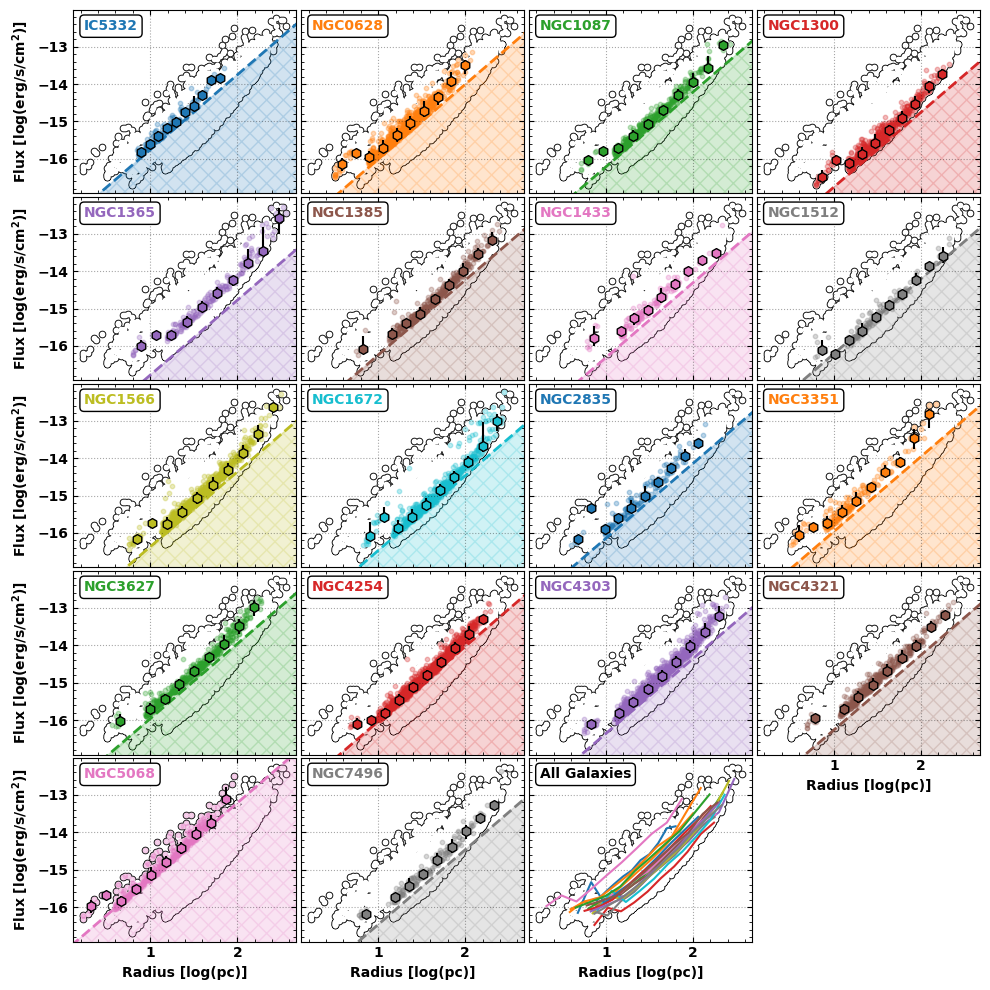

In [18]:
# Get Flux and noise stats
table_noisestats = QTable.read('./tabs/galmap_props.fits')
table_noisestats

std = (table_noisestats['median'] * 1e-20 * u.erg / (u.cm ** 2) / u.s) 
pix = 0.04 * u.arcsec / 2
pix_pc = np.ones(len(std)) * u.pc

# Get radius in pc
for i, gal_name in enumerate(np.unique(table['gal_name'])):
    mask = sample_table['name'] == gal_name.lower()
    dist = sample_table['dist'][mask][0]
    pix_pc[i] = cat_props.calculate_radius(pix, dist)  

### Plot 
data_x = np.log10(table['radius_circ_pc'].value)
data_y = np.log10(table['HA6562_FLUX_HST'].value *1e-20)

fig = plt.figure(figsize=(10, 10)) 

gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    ax.scatter(data_x_, data_y_, s=10, c='C%i'%i, alpha=0.3, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1.5)
    ax.scatter(x, y, s=50, ec='black', fc='C%i' %i, zorder=10, marker='h')

    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [14,15,16,17]:
        ax.set_xlabel('Radius [log(pc)]')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12,16]:
        ax.set_ylabel('Flux [log(erg/s/cm$^2$)]')
    else:
        ax.set_yticklabels([])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.plot([np.log10(pix_pc[i].value), np.log10(pix_pc.value[i]*np.sqrt(1e6))], 
            [np.log10(std[i].value), np.log10(std.value[i]*1e6)], 'C%i'%i, ls='--', lw=2)
    
    ax.fill_between([np.log10(pix_pc[i].value), np.log10(pix_pc.value[i]*np.sqrt(1e6))], 
            [np.log10(std[i].value), np.log10(std.value[i]*1e6)], y2=-100, fc='C%i'%i, ec='C%i'%i, alpha=0.2, hatch='XX', rasterized=True)

ax = fig.add_subplot(5,4,i+2)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

for i, gal_name in enumerate(gal_names):

    mask_gal = table['gal_name'] == gal_name
    data_x_, data_y_ = data_x[mask_gal], data_y[mask_gal]

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.plot(x, y, c='C%i' %i)

    ax.set_yticklabels([])

ax.grid(True, alpha=0.35, ls=':', color='black')
ax.text(0.05, 0.95, 'All Galaxies', ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='k')
ax.set_xlabel('Radius [log(pc)]')

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_radflux_sep_sdlimit.pdf', dpi=150, bbox_inches='tight')

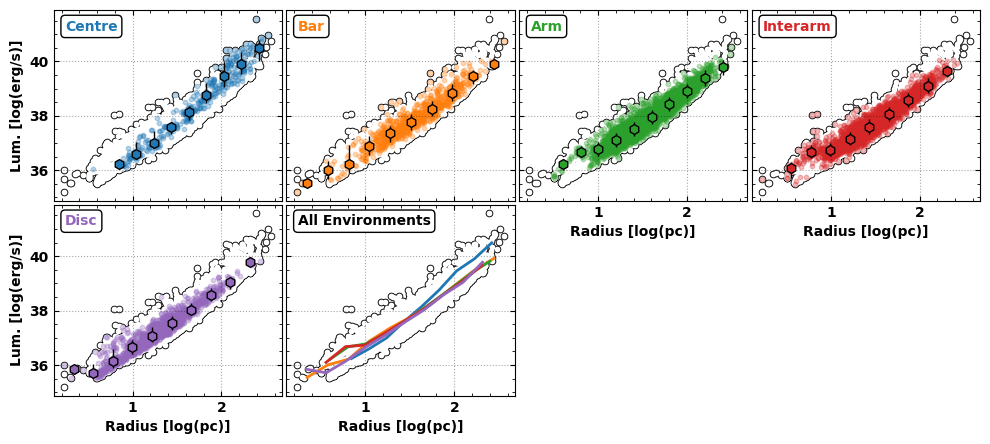

In [19]:
data_x = np.log10(table['radius_circ_pc'].value)
data_y = np.log10(table['HA6562_LUMINOSITY_HST'].value)

fig = plt.figure(figsize=(10, 10)) 

# environments = np.unique(table['Environment'])
environments = [[1], [2,3], [5,6], [4,7,8], [9]]
environments_names = ['Centre', 'Bar', 'Arm', 'Interarm', 'Disc']

for i, environment in enumerate(environments):

    ax = fig.add_subplot(5,4,i+1)

    ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

    mask_env = sum(([table['Environment_MUSE'] == env for env in environment])) == 1

    data_x_, data_y_ = data_x[mask_env], data_y[mask_env]

    ax.scatter(data_x_, data_y_, s=10, c='C%i'%i, alpha=0.3, rasterized=True)

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax.scatter(x, y, s=50, ec='black', fc='C%i' %i, zorder=10, marker='h')

    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, environments_names[i], ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)

    if i in [1,2,3,4]:
        ax.set_xlabel('Radius [log(pc)]')
    else: 
        ax.set_xticklabels([])
    if i in [0,4,8,12]:
        ax.set_ylabel('Lum. [log(erg/s)]')
    else:
        ax.set_yticklabels([])

ax = fig.add_subplot(5,4,i+2)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)

for i, environment in enumerate(environments):

    mask_env = sum(([table['Environment_MUSE'] == env for env in environment])) == 1
    data_x_, data_y_ = data_x[mask_env], data_y[mask_env]

    x, y, stats, bins = get_bins_1d(data_x_, data_y_, nbins=10)
    ax.plot(x, y, c='C%i' %i, lw=2)

    ax.set_yticklabels([])

ax.grid(True, alpha=0.35, ls=':', color='black')
ax.text(0.05, 0.95, 'All Environments', ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='k')
ax.set_xlabel('Radius [log(pc)]')

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/scatter_radlum_env.pdf', dpi=150, bbox_inches='tight')

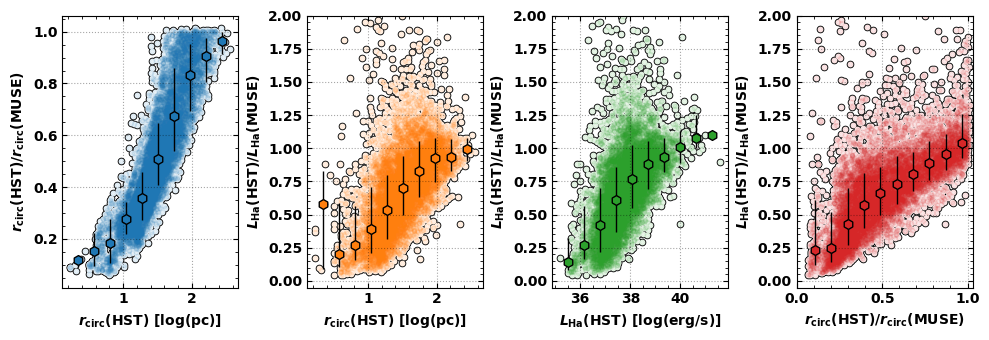

In [20]:
data_x1 = table['radius_circ_pc'].value
data_y1 = table['HA6562_LUMINOSITY_HST'].value
data_x1_log = np.log10(data_x1.copy())
data_y1_log = np.log10(data_y1.copy())

data_x2 = table['region_circ_rad_pc_MUSE'].value
data_y2 = table['HA6562_LUMINOSITY_MUSE'].value

data_x = data_x1/data_x2
data_y = data_y1/data_y2

fig = plt.figure(figsize=(10, 3.5)) 
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.scatter(data_x1_log, data_x, s=20, c='black', rasterized=True)
ax1.scatter(data_x1_log, data_x, s=10, c='white', rasterized=True)
ax1.scatter(data_x1_log, data_x, s=10, alpha=0.1, c='C0', rasterized=True)

ax2.scatter(data_x1_log, data_y, s=20, c='black', rasterized=True)
ax2.scatter(data_x1_log, data_y, s=10, c='white', rasterized=True)
ax2.scatter(data_x1_log, data_y, s=10, alpha=0.1, c='C1', rasterized=True)

ax3.scatter(data_y1_log, data_y, s=20, c='black', rasterized=True)
ax3.scatter(data_y1_log, data_y, s=10, c='white', rasterized=True)
ax3.scatter(data_y1_log, data_y, s=10, alpha=0.1, c='C2', rasterized=True)

ax4.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax4.scatter(data_x, data_y, s=10, c='white', rasterized=True)
ax4.scatter(data_x, data_y, s=10, alpha=0.1, c='C3', rasterized=True)

x, y, stats, bins = get_bins_1d(data_x1_log, data_x)
ax1.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax1.scatter(x, y, s=50, ec='black', fc='C0', zorder=10, marker='h')

x, y, stats, bins = get_bins_1d(data_x1_log, data_y)
ax2.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax2.scatter(x, y, s=50, ec='black', fc='C1', zorder=10, marker='h')

x, y, stats, bins = get_bins_1d(data_y1_log, data_y)
ax3.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax3.scatter(x, y, s=50, ec='black', fc='C2', zorder=10, marker='h')

x, y, stats, bins = get_bins_1d(data_x, data_y)
ax4.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax4.scatter(x, y, s=50, ec='black', fc='C3', zorder=10, marker='h')

ax1.grid(True, alpha=0.35, ls=':', color='black')
ax2.grid(True, alpha=0.35, ls=':', color='black')
ax3.grid(True, alpha=0.35, ls=':', color='black')
ax4.grid(True, alpha=0.35, ls=':', color='black')

ax1.set_xlabel('$r_\mathrm{circ}(\mathrm{HST})$ [log(pc)]')
ax2.set_xlabel('$r_\mathrm{circ}(\mathrm{HST})$ [log(pc)]')
ax1.set_ylabel('$r_\mathrm{circ}(\mathrm{HST})/r_\mathrm{circ}(\mathrm{MUSE})$')
ax3.set_xlabel('$L_\mathrm{Ha}(\mathrm{HST})$ [log(erg/s)]')
ax4.set_xlabel('$r_\mathrm{circ}(\mathrm{HST})/r_\mathrm{circ}(\mathrm{MUSE})$')
ax2.set_ylabel('$L_\mathrm{Ha}(\mathrm{HST})/L_\mathrm{Ha}(\mathrm{MUSE})$')
ax3.set_ylabel('$L_\mathrm{Ha}(\mathrm{HST})/L_\mathrm{Ha}(\mathrm{MUSE})$')
ax4.set_ylabel('$L_\mathrm{Ha}(\mathrm{HST})/L_\mathrm{Ha}(\mathrm{MUSE})$')

# ax3.set_yticklabels([])
# ax4.set_yticklabels([])

ax2.set_ylim(-0.05, 2)
ax3.set_ylim(-0.05, 2)
ax4.set_ylim(-0.05, 2)
ax4.set_xlim(0, 1.03)

fig.tight_layout(h_pad=0.5, w_pad=0.5)
# fig.subplots_adjust(wspace=0.2, hspace=0.02)

plt.savefig('./figs/scatter_radlumratios_all.pdf', dpi=200, bbox_inches='tight')

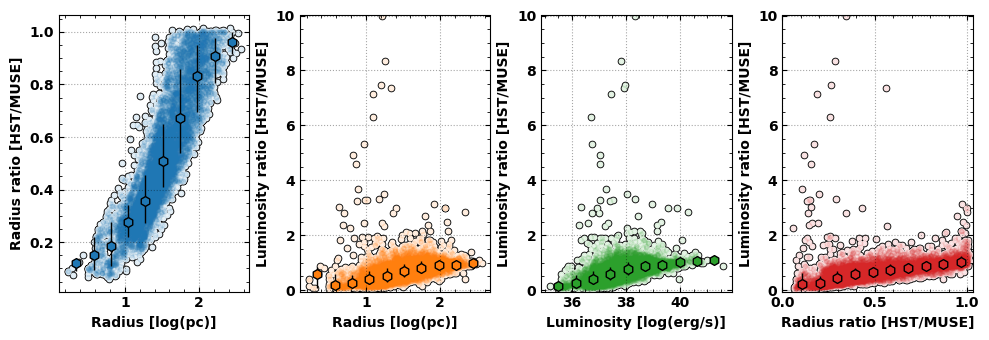

In [21]:
data_x1 = table['radius_circ_pc'].value
data_y1 = table['HA6562_LUMINOSITY_HST'].value
data_x1_log = np.log10(data_x1.copy())
data_y1_log = np.log10(data_y1.copy())

data_x2 = table['region_circ_rad_pc_MUSE'].value
data_y2 = table['HA6562_LUMINOSITY_MUSE'].value

data_x = data_x1/data_x2
data_y = data_y1/data_y2

fig = plt.figure(figsize=(10, 3.5)) 
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.scatter(data_x1_log, data_x, s=20, c='black', rasterized=True)
ax1.scatter(data_x1_log, data_x, s=10, c='white', rasterized=True)
ax1.scatter(data_x1_log, data_x, s=10, alpha=0.1, c='C0', rasterized=True)

ax2.scatter(data_x1_log, data_y, s=20, c='black', rasterized=True)
ax2.scatter(data_x1_log, data_y, s=10, c='white', rasterized=True)
ax2.scatter(data_x1_log, data_y, s=10, alpha=0.1, c='C1', rasterized=True)

ax3.scatter(data_y1_log, data_y, s=20, c='black', rasterized=True)
ax3.scatter(data_y1_log, data_y, s=10, c='white', rasterized=True)
ax3.scatter(data_y1_log, data_y, s=10, alpha=0.1, c='C2', rasterized=True)

ax4.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax4.scatter(data_x, data_y, s=10, c='white', rasterized=True)
ax4.scatter(data_x, data_y, s=10, alpha=0.1, c='C3', rasterized=True)

x, y, stats, bins = get_bins_1d(data_x1_log, data_x)
ax1.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax1.scatter(x, y, s=50, ec='black', fc='C0', zorder=10, marker='h')

x, y, stats, bins = get_bins_1d(data_x1_log, data_y)
ax2.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax2.scatter(x, y, s=50, ec='black', fc='C1', zorder=10, marker='h')

x, y, stats, bins = get_bins_1d(data_y1_log, data_y)
ax3.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax3.scatter(x, y, s=50, ec='black', fc='C2', zorder=10, marker='h')

x, y, stats, bins = get_bins_1d(data_x, data_y)
ax4.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax4.scatter(x, y, s=50, ec='black', fc='C3', zorder=10, marker='h')

ax1.grid(True, alpha=0.35, ls=':', color='black')
ax2.grid(True, alpha=0.35, ls=':', color='black')
ax3.grid(True, alpha=0.35, ls=':', color='black')
ax4.grid(True, alpha=0.35, ls=':', color='black')

ax1.set_xlabel('Radius [log(pc)]')
ax2.set_xlabel('Radius [log(pc)]')
ax1.set_ylabel('Radius ratio [HST/MUSE]')
ax3.set_xlabel('Luminosity [log(erg/s)]')
ax4.set_xlabel('Radius ratio [HST/MUSE]')
ax2.set_ylabel('Luminosity ratio [HST/MUSE]')
ax3.set_ylabel('Luminosity ratio [HST/MUSE]')
ax4.set_ylabel('Luminosity ratio [HST/MUSE]')

# ax3.set_yticklabels([])
# ax4.set_yticklabels([])

ax2.set_ylim(-0.05, 10)
ax3.set_ylim(-0.05, 10)
ax4.set_ylim(-0.05, 10)
ax4.set_xlim(0, 1.03)

fig.tight_layout(h_pad=0.5, w_pad=0.5)
# fig.subplots_adjust(wspace=0.2, hspace=0.02)

plt.savefig('./figs/scatter_radlumratios_all_larger.pdf', dpi=200, bbox_inches='tight')

In [22]:
gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):
    mask = table['gal_name'] == gal_name

    data_x1 = table['radius_circ_pc'].value[mask]
    data_y1 = table['HA6562_LUMINOSITY_HST'].value[mask]
    data_x1_log = np.log10(data_x1.copy())
    data_y1_log = np.log10(data_y1.copy())

    data_x2 = table['region_circ_rad_pc_MUSE'].value[mask]
    data_y2 = table['HA6562_LUMINOSITY_MUSE'].value[mask]

    data_x = data_x1/data_x2
    data_y = data_y1/data_y2

    fig = plt.figure(figsize=(10, 3.5)) 
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)

    ax1.scatter(data_x1_log, data_x, s=20, c='black', rasterized=True)
    ax1.scatter(data_x1_log, data_x, s=10, c='white', rasterized=True)
    ax1.scatter(data_x1_log, data_x, s=10, alpha=0.1, c='C0')

    ax2.scatter(data_x1_log, data_y, s=20, c='black', rasterized=True)
    ax2.scatter(data_x1_log, data_y, s=10, c='white', rasterized=True)
    ax2.scatter(data_x1_log, data_y, s=10, alpha=0.1, c='C1')

    ax3.scatter(data_y1_log, data_y, s=20, c='black', rasterized=True)
    ax3.scatter(data_y1_log, data_y, s=10, c='white', rasterized=True)
    ax3.scatter(data_y1_log, data_y, s=10, alpha=0.1, c='C2')

    ax4.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax4.scatter(data_x, data_y, s=10, c='white', rasterized=True)
    ax4.scatter(data_x, data_y, s=10, alpha=0.1, c='C3')

    x, y, stats, bins = get_bins_1d(data_x1_log, data_x)
    ax1.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax1.scatter(x, y, s=50, ec='black', fc='C0', zorder=10, marker='h')

    x, y, stats, bins = get_bins_1d(data_x1_log, data_y)
    ax2.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax2.scatter(x, y, s=50, ec='black', fc='C1', zorder=10, marker='h')

    x, y, stats, bins = get_bins_1d(data_y1_log, data_y)
    ax3.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax3.scatter(x, y, s=50, ec='black', fc='C2', zorder=10, marker='h')

    x, y, stats, bins = get_bins_1d(data_x, data_y)
    ax4.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
    ax4.scatter(x, y, s=50, ec='black', fc='C3', zorder=10, marker='h')

    ax1.grid(True, alpha=0.35, ls=':', color='black')
    ax2.grid(True, alpha=0.35, ls=':', color='black')
    ax3.grid(True, alpha=0.35, ls=':', color='black')
    ax4.grid(True, alpha=0.35, ls=':', color='black')

    ax1.set_xlabel('Radius [log(pc)]')
    ax2.set_xlabel('Radius [log(pc)]')
    ax1.set_ylabel('Radius ratio [HST/MUSE]')
    ax3.set_xlabel('Luminosity [log(erg/s)]')
    ax4.set_xlabel('Radius ratio [HST/MUSE]')
    ax2.set_ylabel('Luminosity ratio [HST/MUSE]')
    ax3.set_ylabel('Luminosity ratio [HST/MUSE]')
    ax4.set_ylabel('Luminosity ratio [HST/MUSE]')

    ax1.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax1.transAxes, color='k')

    ax2.set_ylim(-0.05, 3)
    ax3.set_ylim(-0.05, 3)
    ax4.set_ylim(-0.05, 3)
    ax4.set_xlim(0, 1.03)

    fig.tight_layout(h_pad=0.5, w_pad=0.5)
    # fig.subplots_adjust(wspace=0.2, hspace=0.02)

    plt.savefig('./figs/scatter_radlumratios_%s.pdf' %gal_name, dpi=200, bbox_inches='tight')
plt.close('all')

# BPT

In [23]:
oiii = table['OIII5006_FLUX_CORR_MUSE'].value
hb   = table['HB4861_FLUX_CORR_MUSE'].value
ha   = table['HA6562_FLUX_CORR_MUSE'].value
nii  = table['NII6583_FLUX_CORR_MUSE'].value
sii  = table['SII6716_FLUX_CORR_MUSE'].value + table['SII6730_FLUX_CORR_MUSE'].value
oi = table['OI6300_FLUX_CORR_MUSE'].value
# oi   = table['OI6363_FLUX_CORR_MUSE'].value

ha_ew = table['EW_HA6562_fit_MUSE'].value
# ha_ew = table['EW_HA6562_raw_MUSE'].value
# ha_ew = table['EW_HA6562_bgcorr_MUSE'].value

mask_bpt = (table['BPT_NII_MUSE'] != -1) & (table['BPT_SII_MUSE'] != -1) & (table['BPT_OI_MUSE'] != -1) 

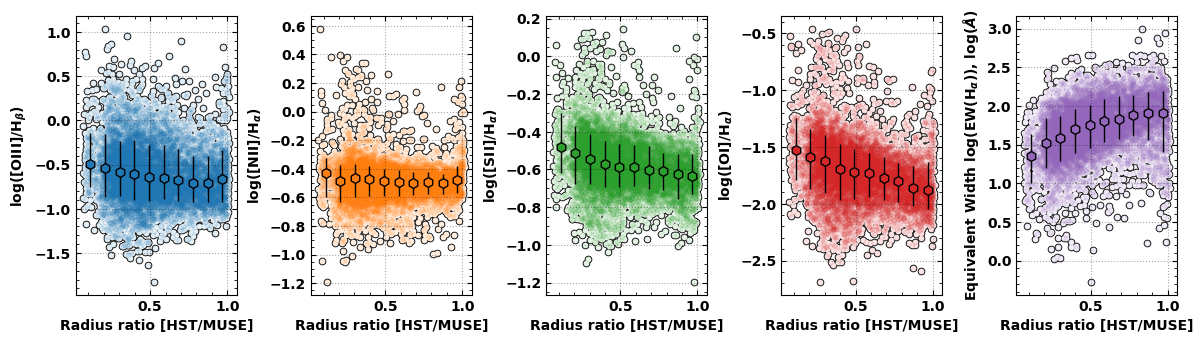

In [24]:
data_x1 = table['radius_circ_pc'].value / table['region_circ_rad_pc_MUSE'].value
data_x1 = data_x1[mask_bpt]

data_y1 = np.log10(oiii/hb)[mask_bpt]
data_y2 = np.log10(nii/ha)[mask_bpt]
data_y3 = np.log10(sii/ha)[mask_bpt]
data_y4 = np.log10(oi/ha)[mask_bpt]
data_y5 = np.log10(ha_ew)[mask_bpt]

fig = plt.figure(figsize=(12, 3.5)) 
ax1 = fig.add_subplot(151)
ax2 = fig.add_subplot(152)
ax3 = fig.add_subplot(153)
ax4 = fig.add_subplot(154)
ax5 = fig.add_subplot(155)

ax1.scatter(data_x1, data_y1, s=20, c='black', rasterized=True)
ax1.scatter(data_x1, data_y1, s=10, c='white', rasterized=True)
ax1.scatter(data_x1, data_y1, s=10, alpha=0.1, c='C0', rasterized=True)

ax2.scatter(data_x1, data_y2, s=20, c='black', rasterized=True)
ax2.scatter(data_x1, data_y2, s=10, c='white', rasterized=True)
ax2.scatter(data_x1, data_y2, s=10, alpha=0.1, c='C1', rasterized=True)

ax3.scatter(data_x1, data_y3, s=20, c='black', rasterized=True)
ax3.scatter(data_x1, data_y3, s=10, c='white', rasterized=True)
ax3.scatter(data_x1, data_y3, s=10, alpha=0.1, c='C2', rasterized=True)

ax4.scatter(data_x1, data_y4, s=20, c='black', rasterized=True)
ax4.scatter(data_x1, data_y4, s=10, c='white', rasterized=True)
ax4.scatter(data_x1, data_y4, s=10, alpha=0.1, c='C3', rasterized=True)

ax5.scatter(data_x1, data_y5, s=20, c='black', rasterized=True)
ax5.scatter(data_x1, data_y5, s=10, c='white', rasterized=True)
ax5.scatter(data_x1, data_y5, s=10, alpha=0.1, c='C4', rasterized=True)

x, y, stats, bins = get_bins_1d(data_x1, data_y1)
ax1.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax1.scatter(x, y, s=50, ec='black', fc='C0', zorder=10, marker='h')

x, y, stats, bins = get_bins_1d(data_x1, data_y2)
ax2.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax2.scatter(x, y, s=50, ec='black', fc='C1', zorder=10, marker='h')

x, y, stats, bins = get_bins_1d(data_x1, data_y3)
ax3.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax3.scatter(x, y, s=50, ec='black', fc='C2', zorder=10, marker='h')

x, y, stats, bins = get_bins_1d(data_x1, data_y4)
ax4.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax4.scatter(x, y, s=50, ec='black', fc='C3', zorder=10, marker='h')

x, y, stats, bins = get_bins_1d(data_x1, data_y5)
ax5.errorbar(x, y, yerr=[y-stats['-1sigma'], stats['+1sigma']-y], fmt='none', color='black', lw=1)
ax5.scatter(x, y, s=50, ec='black', fc='C4', zorder=10, marker='h')

for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.grid(True, alpha=0.35, ls=':', color='black')
    ax.set_xlabel('Radius ratio [HST/MUSE]')

ax2.set_yticks(np.arange(-1.2, 0.8, 0.2))

ax1.set_ylabel(r'log([OIII]/H$_\beta$)')
ax2.set_ylabel(r'log([NII]/H$_\alpha$)')
ax3.set_ylabel(r'log([SII]/H$_\alpha$)')
ax4.set_ylabel(r'log([OI]/H$_\alpha$)')
ax5.set_ylabel(r'Equivalent Width log(EW(H$_\alpha$)), log($\AA$)')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/scatter_radratios_bpt.pdf', dpi=200, bbox_inches='tight')

In [25]:
def plot_law_2021(ax, bpt_type='NII'):

    if bpt_type=='NII':
        xplot_law2020= np.linspace(-1.5, -0.04, 100)
        yplot_law2020=0.438 / (xplot_law2020 +0.023) + 1.222
        ax.plot(xplot_law2020,yplot_law2020, c='k', ls='-', lw=1)
        
    elif bpt_type=='SII':
        xplot_law2020= np.linspace(-1.5, +0.18, 100)
        yplot_law2020=0.648/ (xplot_law2020 -0.324) + 1.349
        ax.plot(xplot_law2020,yplot_law2020, c='k', ls='-', lw=1)
        
    elif bpt_type=='OI':
        xplot_law2020= np.linspace(-3.3, -0.37, 100)
        yplot_law2020=0.884/ (xplot_law2020 +0.124) + 1.291
        ax.plot(xplot_law2020,yplot_law2020, c='k', ls='-', lw=1)
        
def draw_lines_bpt_nii(ax, xlim=[-0.9, 0.35], ylim=[-1.25, 1.] ):
    xplotBPT1= np.linspace(-1.5, 0.04, 100)
    xplotBPT2= np.linspace(-1.5, 0.45, 100)
    #    K03
    #condition for a pixel to represent AGN or shoch ionisation is OIII_HB > BPT_r parametrised by Kauffmann
    BPT_r=0.61 / (xplotBPT1 -0.05) + 1.3
    #condition for a pixel to represent AGN or shoch ionisation is OIII_HB > BPT_r parametrised by Kewley
    BPT_r2 = 0.61 /( xplotBPT2 - 0.47 ) + 1.19
    
    ax.plot(xplotBPT1,BPT_r , c='k', ls='dotted')
    ax.plot(xplotBPT2,BPT_r2, c='k', ls='--')
    
    plot_law_2021(ax, bpt_type='NII')

    
def draw_lines_bpt_sii(ax, xlim=[-0.9, 0.35], ylim=[-1.25, 1.]):
    xplotBPT1_s= np.linspace(-1.5, 0.31, 100)
    xplotBPT2_s= np.linspace(-0.315, 0.7, 100)
    #    K03
    K01_s= 0.72/(xplotBPT1_s-0.32) +1.3      
    LIER_LINE=1.89*xplotBPT2_s+0.76
    
    ax.plot(xplotBPT1_s,K01_s, c='k', ls='--' )
    ax.plot(xplotBPT2_s,LIER_LINE, c='k', ls='--')

    plot_law_2021(ax, bpt_type='SII')


def draw_lines_bpt_oi(ax, xlim=[-2.2, -0.5], ylim=[-1.25, 1.] ):

    xplotBPT1= np.linspace(-3.3, -0.6, 100)
    BPT_r=0.73 / (xplotBPT1 +0.59) + 1.3
    ax.plot(xplotBPT1,BPT_r, c='k' , ls='--' )

    plot_law_2021(ax, bpt_type='OI')

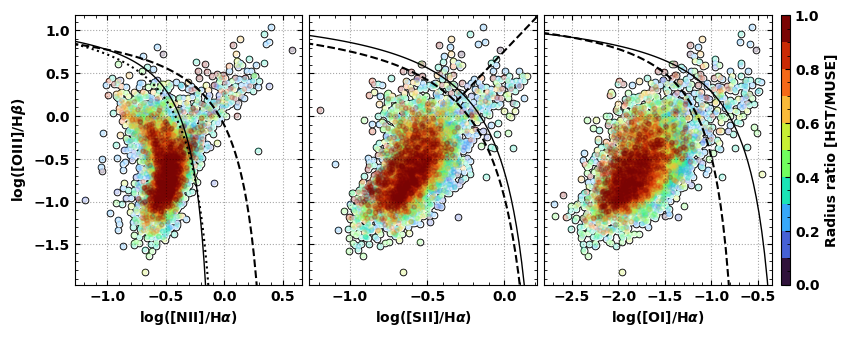

In [26]:
data_x1 = table['radius_circ_pc'].value / table['region_circ_rad_pc_MUSE'].value
data_x1 = data_x1[mask_bpt]
argsort = np.argsort(data_x1)
data_x1 = data_x1[argsort]

data_y1 = np.log10(oiii/hb)[mask_bpt][argsort]
data_y2 = np.log10(nii/ha)[mask_bpt][argsort]
data_y3 = np.log10(sii/ha)[mask_bpt][argsort]
data_y4 = np.log10(oi/ha)[mask_bpt][argsort]

fig = plt.figure(figsize=(9, 3.5)) 
fig.tight_layout(w_pad=0, h_pad=0)
fig.subplots_adjust(wspace=0.03)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

cmap = mpl.cm.get_cmap('turbo', 10)
norm = mpl.colors.Normalize(vmin=0, vmax=1)

ax1.scatter(data_y2, data_y1, s=20, c='black', rasterized=True)
ax1.scatter(data_y2, data_y1, s=10, c='white', rasterized=True)
ax1.scatter(data_y2, data_y1, s=10, alpha=0.2, c=data_x1, cmap=cmap,  norm=norm, rasterized=True)

ax2.scatter(data_y3, data_y1, s=20, c='black', rasterized=True)
ax2.scatter(data_y3, data_y1, s=10, c='white', rasterized=True)
ax2.scatter(data_y3, data_y1, s=10, alpha=0.2, c=data_x1, cmap=cmap,  norm=norm, rasterized=True)

ax3.scatter(data_y4, data_y1, s=20, c='black', rasterized=True)
ax3.scatter(data_y4, data_y1, s=10, c='white', rasterized=True)
ax3.scatter(data_y4, data_y1, s=10, alpha=0.2, c=data_x1, cmap=cmap,  norm=norm, rasterized=True)

ylims1 = ax1.get_ylim()
xlims1 = ax1.get_xlim()
xlims2 = ax2.get_xlim()
xlims3 = ax3.get_xlim()

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(ylims1)

ax1.set_xlim(xlims1)
ax2.set_xlim(xlims2)
ax3.set_xlim(xlims3)

draw_lines_bpt_nii(ax1)
draw_lines_bpt_sii(ax2)
draw_lines_bpt_oi(ax3)

for ax in [ax1, ax2, ax3]:
    ax.grid(True, alpha=0.35, ls=':', color='black')

# Create a new axis for the colorbar
cbar_ax = fig.add_axes([ax3.get_position().x1+0.01, ax3.get_position().y0, 0.01, ax3.get_position().height])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Radius ratio [HST/MUSE]')

ax1.set_ylabel(r'log([OIII]/H$\beta$)')
ax1.set_xlabel(r'log([NII]/H$\alpha$)')
ax2.set_xlabel(r'log([SII]/H$\alpha$)')
ax3.set_xlabel(r'log([OI]/H$\alpha$)')

ax2.set_yticklabels([])
ax3.set_yticklabels([])

plt.savefig('./figs/scatter_gpt.pdf', dpi=200, bbox_inches='tight')

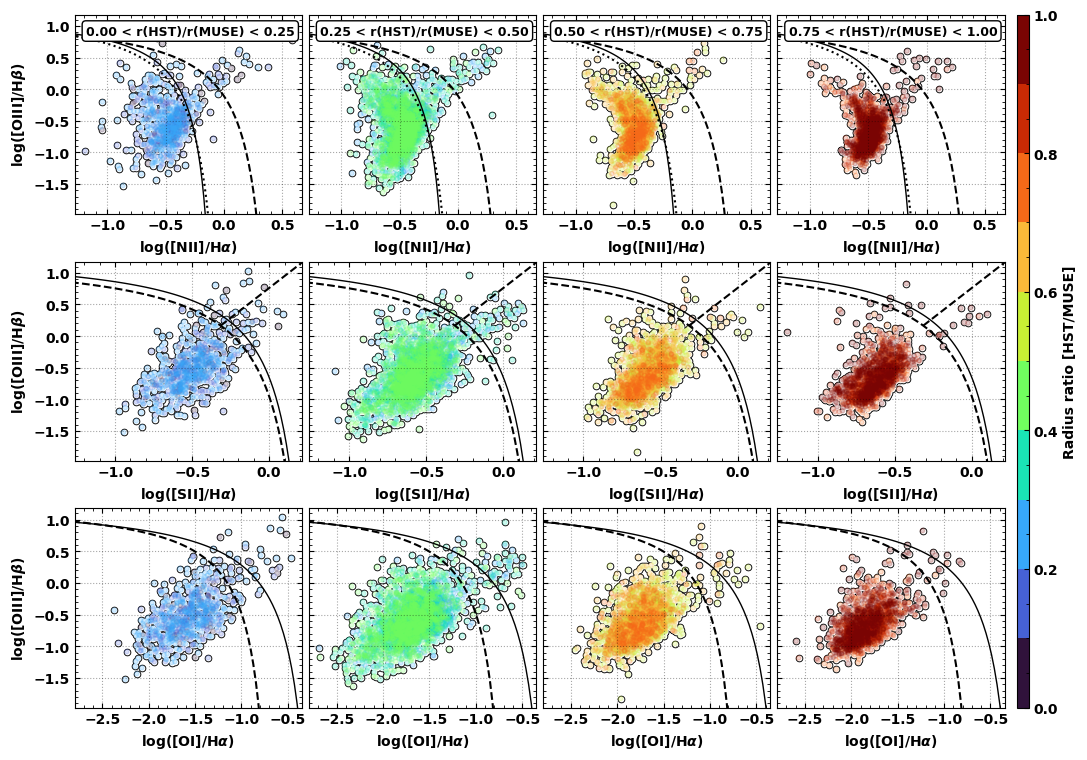

In [27]:
data_x1 = table['radius_circ_pc'].value / table['region_circ_rad_pc_MUSE'].value
data_x1 = data_x1[mask_bpt]
argsort = np.argsort(data_x1)
data_x1 = data_x1[argsort]

data_y1 = np.log10(oiii/hb)[mask_bpt][argsort]
data_y2 = np.log10(nii/ha)[mask_bpt][argsort]
data_y3 = np.log10(sii/ha)[mask_bpt][argsort]
data_y4 = np.log10(oi/ha)[mask_bpt][argsort]
data_y5 = np.log10(ha_ew)[mask_bpt][argsort]

fig = plt.figure(figsize=(12, 9)) 
fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.24)

norm = mpl.colors.Normalize(vmin=0, vmax=1)
limits = [0,0.25,0.5,0.75,1]

for i in range(4):

    ax1 = fig.add_subplot(3,4,1+i)
    ax2 = fig.add_subplot(3,4,5+i)
    ax3 = fig.add_subplot(3,4,9+i)

    mask = (data_x1 > limits[i]) & (data_x1 < limits[i+1])
    
    ax1.scatter(data_y2[mask], data_y1[mask], s=20, c='black', rasterized=True)
    ax1.scatter(data_y2[mask], data_y1[mask], s=10, c='white', rasterized=True)
    ax1.scatter(data_y2[mask], data_y1[mask], s=10, alpha=0.2, c=data_x1[mask], cmap=cmap, norm=norm, rasterized=True)

    ax2.scatter(data_y3[mask], data_y1[mask], s=20, c='black', rasterized=True)
    ax2.scatter(data_y3[mask], data_y1[mask], s=10, c='white', rasterized=True)
    ax2.scatter(data_y3[mask], data_y1[mask], s=10, alpha=0.2, c=data_x1[mask], cmap=cmap, norm=norm, rasterized=True)

    ax3.scatter(data_y4[mask], data_y1[mask], s=20, c='black', rasterized=True)
    ax3.scatter(data_y4[mask], data_y1[mask], s=10, c='white', rasterized=True)
    ax3.scatter(data_y4[mask], data_y1[mask], s=10, alpha=0.2, c=data_x1[mask], cmap=cmap, norm=norm, rasterized=True)

    draw_lines_bpt_nii(ax1)
    draw_lines_bpt_sii(ax2)
    draw_lines_bpt_oi(ax3)

    for ax in [ax1, ax2, ax3]:
        ax.grid(True, alpha=0.35, ls=':', color='black')

        ax.set_ylim(ylims1)
    ax1.set_xlim(xlims1)
    ax2.set_xlim(xlims2)
    ax3.set_xlim(xlims3)

    ax1.text(0.05, 0.95, '%.2f < r(HST)/r(MUSE) < %.2f' %(limits[i], limits[i+1]), ha='left', va='top', 
             bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax1.transAxes, color='k',
             fontsize=9)

    if i == 0: 
        ax1.set_ylabel(r'log([OIII]/H$\beta$)')
        ax2.set_ylabel(r'log([OIII]/H$\beta$)')
        ax3.set_ylabel(r'log([OIII]/H$\beta$)')
    else: 
        ax1.set_yticklabels([])
        ax2.set_yticklabels([])
        ax3.set_yticklabels([])
    
    if i == 3: 
        cbar_ax = fig.add_axes([ax1.get_position().x1+0.01, ax3.get_position().y0, 0.01, ax1.get_position().y1-ax3.get_position().y0])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, cax=cbar_ax)
        cbar.set_label('Radius ratio [HST/MUSE]')

    ax1.set_xlabel(r'log([NII]/H$\alpha$)')
    ax2.set_xlabel(r'log([SII]/H$\alpha$)')
    ax3.set_xlabel(r'log([OI]/H$\alpha$)')

plt.savefig('./figs/scatter_gpt_rbins.pdf', dpi=200, bbox_inches='tight')

In [28]:
table['complexity_std']/np.sqrt(table['npix'])

<Quantity [25.98719295, 38.87062437, 10.08348156, ...,  5.12235723,
           11.86912316, 78.72848002] 1 / pix(1/2)>

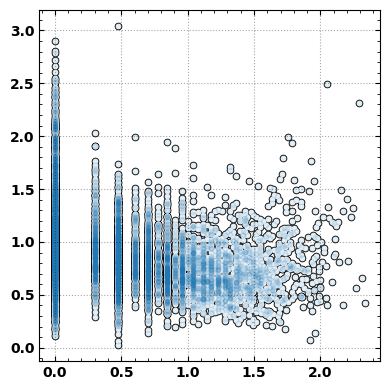

In [29]:
data_x = np.log10(table['complexity_score'])
data_y = np.log10((table['complexity_std']/table['npix']**0.5).value)

fig = plt.figure(figsize=(4, 4)) 
ax = fig.add_subplot(111)

ax.scatter(data_x, data_y, s=20, c='black', rasterized=True)
ax.scatter(data_x, data_y, s=10, c='white', rasterized=True)
ax.scatter(data_x, data_y, s=10, alpha=0.1, rasterized=True)

ax.grid(True, alpha=0.35, ls=':', color='black')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

# plt.savefig('./figs/scatter_radlum_all.pdf', dpi=200, bbox_inches='tight')